<a href="https://colab.research.google.com/github/yarkalm/sale_regression/blob/main/Clean_salest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача регрессии: определить количество покупок в день по дате

In [ ]:
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint
import random
import tensorflow as tf
from keras import models
from keras.layers import Dense, Dropout, LSTM
from keras import Sequential, regularizers
from keras.optimizers import Adam, SGD
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
seed = 3
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#  Загрузка и предобработка данных

In [ ]:
df = pd.read_csv("/content/clean_sales_fabric_96_sku_265_warehouse_1.csv")
date = df['date'].str.split('-').to_numpy()

In [ ]:
for i in range(len(date)):
  date[i] = np.asarray(list(map(int,date[i]))).astype(np.float32)

In [ ]:
year = []
month = []
day = []
for i in range(len(date)):
  today = date[i]
  year.append(today[0])
  month.append(today[1])
  day.append(today[2])

In [ ]:
df['date'] = date
df['year'] = year
df['month'] = month
df['day'] = day
scaler = StandardScaler()
data, target = (scaler.fit_transform(df[['year','month','day']])),df['count'].astype(int)

In [ ]:
x = []
y = []
timesteps = 3
for i in range(timesteps, len(data)):
# Кодирование даты
  x.append(np.array(data[i-timesteps:i]))
  y.append(target[i])
x, y = np.array(x), np.array(y)

In [ ]:
len(x)

186

In [ ]:
x_train, x_test = x[:155], x[155:]
y_train, y_test = y[:155], y[155:]

# Создание модели

In [ ]:
model = Sequential()
model.add(LSTM(16, input_shape=(x_train.shape[1], x_train.shape[-1]), return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))

In [ ]:
def my_metric(y_true, y_pred):
  return (1+y_pred)/(1+y_true)

model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.1),metrics = [my_metric])

In [ ]:
filepath="/content/weights--{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Обучение

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=16,validation_split=0.25, verbose=2, callbacks = callbacks_list)

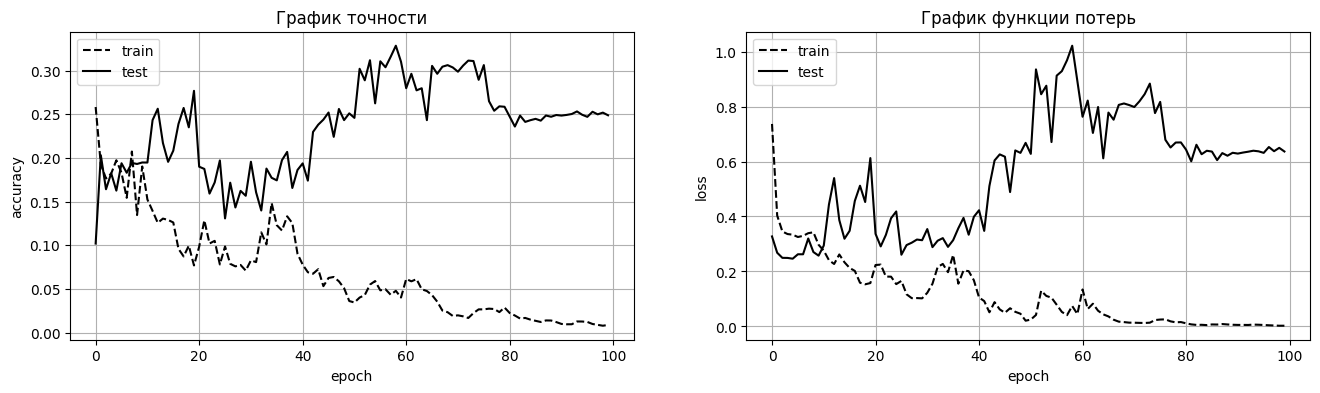

In [ ]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(121)
ax.plot(history.history['my_metric'],'--',color='black')
ax.plot(history.history['val_my_metric'],color='black')
ax.set_title('График точности')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)
ax2 = fig.add_subplot(122)
ax2.plot(history.history['loss'],'--',color='black')
ax2.plot(history.history['val_loss'],color='black')
ax2.set_title('График функции потерь')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
ax2.grid(True)
plt.show()

# Прогнозы на тестовых данных

In [ ]:
model = models.load_model('best.h5', custom_objects={"my_metric": my_metric})

In [ ]:
test = pd.DataFrame()
test['year'] = year[158:]
test['month'] = month[158:]
test['day'] = day[158:]

test['y_pred'] = list(np.around(model.predict(x_test)*1,0))
test['y_real'] = y_test

1/1 [==============================] - 0s 87ms/step


In [ ]:
test

,year,month,day,y_pred,y_real
0,2018.0,8.0,27.0,[1.0],1
1,2017.0,7.0,6.0,[1.0],1
2,2017.0,12.0,4.0,[1.0],1
3,2015.0,10.0,17.0,[1.0],1
4,2015.0,10.0,31.0,[1.0],1
5,2015.0,11.0,5.0,[3.0],3
6,2015.0,11.0,5.0,[1.0],1
7,2015.0,11.0,10.0,[2.0],1
8,2015.0,11.0,19.0,[2.0],2
9,2018.0,7.0,11.0,[2.0],1


In [ ]:
model.save('best.h5')